# MacOS Configuration
The configuration is for
1. Install boost libs: `brew install boost-python3` (My current version is 1.73.0)
2. Install JUCE (Currently I'm still using JUCE 7)
3. Make sure have python3.8 installed
4. Get RenderMan from https://github.com/fedden/RenderMan
5. Open `RenderMan-py36.jucer` in the project folder, generate XCode project.
6. Configure the search paths in XCode (This could be different, find the corresponding paths on your machine):
   - Boost dylib path: `/usr/local/Cellar/boost-python3/1.73.0/lib`
   - Python dylib path: `/usr/local/Cellar/python@3.8/3.8.5/Frameworks/Python.framework/Versions/3.8/lib`
   - Python header path: `/usr/local/Cellar/python@3.8/3.8.5/Frameworks/Python.framework/Versions/3.8/include/python3.8`
7. Set the link flags: `-shared -lboost_python38 -undefined dynamic_lookup`
7. Build a release build `librenderman.so.dylib`, remove the extra `.dylib` extension.
8. Copy the `librenderman.so` to your python project root directory.

# Example
[RenderMan Example](http://doc.gold.ac.uk/~lfedd001/renderman.html)

Now, check if the `librenderman` works properly.

In [1]:
import librenderman as rm

# Important settings. These are good general ones.
sampleRate = 44100
bufferSize = 512
fftSize = 512


# This will host a VST. It will render the features and audio we need.
engine = rm.RenderEngine(sampleRate, bufferSize, fftSize)

Load the VST plugin.

In [2]:
path = "/Library/Audio/Plug-Ins/VST/u-he/Diva.vst"
engine.load_plugin(path)

True

In [4]:

print(engine.get_plugin_parameters_description())


  0: main: Output
  1: main: Active #FX1
  2: main: Active #FX2
  3: PCore: LED Colour
  4: VCC: Voices
  5: VCC: Voice Stack
  6: VCC: Mode
  7: VCC: GlideMode
  8: VCC: Glide
  9: VCC: Glide2
 10: VCC: GlideRange
 11: VCC: PitchBend Up
 12: VCC: PitchBend Down
 13: VCC: TuningMode
 14: VCC: Transpose
 15: VCC: FineTuneCents
 16: VCC: Note Priority
 17: VCC: MultiCore
 18: OPT: Accuracy
 19: OPT: OfflineAcc
 20: OPT: TuneSlop
 21: OPT: CutoffSlop
 22: OPT: GlideSlop
 23: OPT: PWSlop
 24: OPT: EnvrateSlop
 25: OPT: V1Mod
 26: OPT: V2Mod
 27: OPT: V3Mod
 28: OPT: V4Mod
 29: OPT: V5Mod
 30: OPT: V6Mod
 31: OPT: V7Mod
 32: OPT: V8Mod
 33: ENV1: Attack
 34: ENV1: Decay
 35: ENV1: Sustain
 36: ENV1: Release
 37: ENV1: Velocity
 38: ENV1: Model
 39: ENV1: Trigger
 40: ENV1: Quantise
 41: ENV1: Curve
 42: ENV1: Release On
 43: ENV1: KeyFollow
 44: ENV2: Attack
 45: ENV2: Decay
 46: ENV2: Sustain
 47: ENV2: Release
 48: ENV2: Velocity
 49: ENV2: Model
 50: ENV2: Trigger
 51: ENV2: Quantise
 52

In [5]:
# Create a patch generator. We can initialise it to generate the correct
# patches for a given synth by passing it a RenderEngine which has
# loaded a instance of the synthesiser. 
generator = rm.PatchGenerator(engine)
new_patch = generator.get_random_patch()
engine.set_patch(new_patch)

midiNote = 40
midiVelocity = 127
noteLength = 4.0
renderLength = 5.0

# Render the data. 
engine.render_patch(midiNote, midiVelocity, noteLength, renderLength)

# Get the data. Note the audio is automattically made mono, no
# matter what channel size for ease of use.
audio = engine.get_audio_frames()
#mfccs = engine.get_mfcc_features()

# Get the patch and display it!
patch = engine.get_patch()

# The patch is just a list of tuples, one int for index
# and one float for the value. I've printed out the patch,
# note the overriden parameters are the correct ones!
for parameter in patch:
    
    # Unpack and print the parameter tuple.
    index, value = parameter
    print("Index: " + '{:3d}'.format(index) + " --- Value: " + str(value))


Index:   0 --- Value: 0.5135504007339478
Index:   1 --- Value: 0.4280327260494232
Index:   2 --- Value: 0.7708219289779663
Index:   3 --- Value: 0.9193716049194336
Index:   4 --- Value: 0.31025514006614685
Index:   5 --- Value: 0.9179643988609314
Index:   6 --- Value: 0.2823936343193054
Index:   7 --- Value: 0.8022554516792297
Index:   8 --- Value: 0.48036617040634155
Index:   9 --- Value: 0.045254431664943695
Index:  10 --- Value: 0.4881500005722046
Index:  11 --- Value: 0.24357227981090546
Index:  12 --- Value: 0.5568934679031372
Index:  13 --- Value: 0.14679940044879913
Index:  14 --- Value: 0.6893166303634644
Index:  15 --- Value: 0.19024670124053955
Index:  16 --- Value: 0.973541796207428
Index:  17 --- Value: 0.40760311484336853
Index:  18 --- Value: 0.5277866721153259
Index:  19 --- Value: 0.2336636632680893
Index:  20 --- Value: 0.04118514060974121
Index:  21 --- Value: 0.39646509289741516
Index:  22 --- Value: 0.4707491397857666
Index:  23 --- Value: 0.48758459091186523
Index:

Text(0.5, 0, 'Time (frame count)')

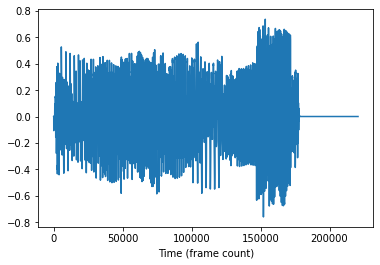

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(audio)
plt.xlabel('Time (frame count)')

/Users/yilin/miniconda3/envs/renderman/lib/python3.8/site-packages/matplotlib/axes/_axes.py:7558: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


Text(0, 0.5, 'Frequency')

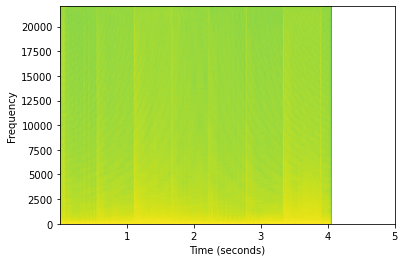

In [7]:
plt.specgram(audio, NFFT=512, Fs=sampleRate, noverlap=256)

# Plot a spectrogram
plt.xlabel('Time (seconds)')
plt.ylabel('Frequency')


In [8]:
from IPython.display import Audio

Audio(audio, rate=sampleRate)